In [18]:
import os
import numpy as np
import re
import scipy.io as sio
import torch
from torch.utils.data import Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from braindecode.preprocessing import exponential_moving_standardize
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp

In [19]:
class NguyenDataset(Dataset):
    def __init__(self, data_dirs, num_participants = 5, selected_labels_short = [1, 2], selected_labels_long = [1, 2], num_samples_per_label = 36, transform = None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.num_samples_per_label = num_samples_per_label
        
        self.label_map_short = {1: 0, 2: 1}
        self.label_map_long = {1: 2, 2: 3}

        self.selected_labels_short = set(selected_labels_short)
        self.selected_labels_long = set(selected_labels_long)

        for data_dir in data_dirs: 
            session_type = "short" if "Short_words" in data_dir.lower() else "long"
            seen_participants = set()

            for file in os.listdir(data_dir):
                if not file.endswith(".mat"):
                    continue

                base = os.path.basename(file)
                match = re.search(r"sub[_\-]?(\d+)", file)
                if not match: 
                    continue
                participant_id = int(match.group(1))
                if participant_id not in seen_participants and len(seen_participants) < num_participants:
                    seen_participants.add(participant_id)
                elif participant_id not in seen_participants:
                    continue

                file_path = os.path.join(data_dir, file)
                self._process_mat_file(file_path, session_type)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        print(f"Final dataset size: {self.data.shape}, Labels shape: {self.labels.shape}")

    def _process_mat_file(self, file_path, session_type):
        mat = sio.loadmat(file_path)
        data_key = 'eeg_data_wrt_task_rep_no_eog_256Hz_last_beep'
        if session_type == "short":
            label_map = self.label_map_short
            selected_labels = self.selected_labels_short
        else:
            label_map = self.label_map_long
            selected_labels = self.selected_labels_long
        
        eeg_cells = mat[data_key]

        for label_idx in selected_labels:
            trials = eeg_cells[label_idx - 1]
            trial_indices = np.arange(len(trials))
            np.random.shuffle(trial_indices)
            trial_indices = trial_indices[:self.num_samples_per_label]

            for idx in trial_indices:
                trial_data = trials[idx]
                if trial_data.size == 0:
                    continue
                if trial_data.shape[0] > 64:
                    trial_data = trial_data[:64, :]
                self.data.append(trial_data)
                self.labels.append(label_map[label_idx])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [20]:
# preprocess data
def preprocess_data(X):
    X = X * 1e6
    X = exponential_moving_standardize(X, factor_new = 1e-3, init_block_size = 1000)
    return X

In [23]:
# for optimized hyperparameters
class EEGExperiment:
    def __init__(self, data_dirs, epochs=15):
        self.data_dirs = data_dirs
        self.epochs = epochs

    def _load_data(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        dataset = NguyenDataset(self.data_dirs)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])
        return train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

    def _train_model(self, X_train, y_train, X_val, y_val, lr, batch_size):
        n_classes = 4
        n_chans, input_time_length = X_train.shape[1], X_train.shape[2]

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length='auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            optimizer__lr=lr,
            train_split=predefined_split(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())),
            batch_size=batch_size,
            callbacks=[
                'accuracy',
                ('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max=self.epochs - 1))
            ],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            classes=list(range(n_classes))
        )

        clf.fit(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), y=None, epochs=self.epochs)
        return clf

    def run(self, learning_rates, batch_sizes, repeats=10):
        best_acc = 0
        best_config = None

        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nTesting config: lr = {lr}, batch_size = {batch_size}")
                X_train, X_val, y_train, y_val = self._load_data(seed = 2025)
                clf = self._train_model(X_train, y_train, X_val, y_val, lr, batch_size)
                acc = float(clf.history[-1, 'valid_accuracy'])

                print(f" → Accuracy: {acc:.4f}")
                if acc > best_acc:
                    best_acc = acc
                    best_config = {'lr': lr, 'batch_size': batch_size}

        print(f"\nBest config: {best_config}, Accuracy: {best_acc:.4f}")

        all_histories = []
        val_accuracies = []

        for i in range(repeats):
            print(f"Repeat {i+1}/{repeats}")
            X_train, X_val, y_train, y_val = self._load_data(seed = 2025 + i)
            clf = self._train_model(X_train, y_train, X_val, y_val,
                                    best_config['lr'], best_config['batch_size'])
            acc = float(clf.history[-1, 'valid_accuracy'])
            val_accuracies.append(acc)
            all_histories.append(clf.history)

        mean_acc = np.mean(val_accuracies)
        std_acc = np.std(val_accuracies)
        print(f"\nFinal result — Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

        return {
            'best_model': clf,
            'best_config': best_config,
            'all_accuracies': val_accuracies,
            'all_histories': all_histories,
            'mean_acc': mean_acc,
            'std_acc': std_acc
        }

In [24]:
data_dirs = ['/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/Nguyen/Long_words', '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/Nguyen/Short_words']

experiment = EEGExperiment(data_dirs=data_dirs, epochs=15)
results = experiment.run(
    learning_rates=[0.001, 0.0005],
    batch_sizes=[32, 64],
    repeats=10
)

print("Best hyperparameters:", results['best_config'])
print("Validation accuracies:", results['all_accuracies'])


Testing config: lr = 0.001, batch_size = 32
Final dataset size: (720, 64, 1280), Labels shape: (720,)


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.6111        1.0896       0.5417            0.5417        0.8382  0.0010  9.1609
      2            0.7326        0.7510       0.4444            0.4444        0.8432  0.0010  8.8387
      3            0.8073        0.6121       0.5625            0.5625        0.7654  0.0010  8.7878
      4            0.8455        0.6127       0.5000            0.5000        0.8269  0.0009  9.3513
      5            0.8507        0.5255       0.5347            0.5347        0.7891  0.0008  9.2905
      6            0.9219        0.5082       0.5417            0.5417        0.8031  0.0007  8.7476
      7            0.9497        0.4688       0.5486            0.5486        0.8122  0.0006  9.2853
      8            0.9427        0.3805       0.4931            0.4931        0.8393  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5677        1.1430       0.5139            0.5139        0.9931  0.0010  4.5773
      2            0.7031        0.7845       0.5556            0.5556        0.7407  0.0010  4.5482
      3            0.7604        0.6392       0.5347            0.5347        0.7721  0.0010  4.4788
      4            0.8299        0.6338       0.5347            0.5347        0.7858  0.0009  4.4923
      5            0.8438        0.5573       0.5347            0.5347        0.7867  0.0008  4.6799
      6            0.8906        0.5295       0.5208            0.5208        0.7989  0.0007  5.0525
      7            0.9097        0.4929       0.5486            0.5486        0.7775  0.0006  5.0172
      8            0.9271        0.4265       0.5694            0.5694        0.7825  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.6059        1.1249       0.5347            0.5347        0.8498  0.0005  5.2080
      2            0.7413        0.7649       0.5139            0.5139        0.7714  0.0005  5.5082
      3            0.8229        0.6146       0.5556            0.5556        0.7559  0.0005  5.0516
      4            0.8750        0.6055       0.5347            0.5347        0.7795  0.0004  4.8641
      5            0.8646        0.5365       0.5347            0.5347        0.7738  0.0004  4.7502
      6            0.9444        0.5053       0.5347            0.5347        0.7950  0.0004  4.4655
      7            0.9427        0.4705       0.5417            0.5417        0.7696  0.0003  4.5456
      8            0.9497        0.4071       0.5347            0.5347        0.7846  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5920        1.2292       0.5000            0.5000        0.8500  0.0005  4.4642
      2            0.7205        0.8057       0.5069            0.5069        0.7747  0.0005  4.5279
      3            0.7760        0.6556       0.5139            0.5139        0.7639  0.0005  4.4760
      4            0.8385        0.6415       0.5625            0.5625        0.7844  0.0004  4.4957
      5            0.8767        0.5830       0.5000            0.5000        0.7761  0.0004  4.4611
      6            0.8924        0.5436       0.5139            0.5139        0.7763  0.0004  4.5586
      7            0.9167        0.5049       0.5556            0.5556        0.7701  0.0003  4.4272
      8            0.9375        0.4499       0.5556            0.5556        0.7750  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5920        1.2292       0.5000            0.5000        0.8500  0.0005  4.5766
      2            0.7205        0.8057       0.5069            0.5069        0.7747  0.0005  4.4862
      3            0.7760        0.6556       0.5139            0.5139        0.7639  0.0005  4.4487
      4            0.8385        0.6415       0.5625            0.5625        0.7844  0.0004  4.5033
      5            0.8767        0.5830       0.5000            0.5000        0.7761  0.0004  4.4810
      6            0.8924        0.5436       0.5139            0.5139        0.7763  0.0004  4.4544
      7            0.9167        0.5049       0.5556            0.5556        0.7701  0.0003  4.4894
      8            0.9375        0.4499       0.5556            0.5556        0.7750  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5052        1.2714       0.5000            0.5000        1.3337  0.0005  4.5526
      2            0.5156        0.8159       0.4931            0.4931        1.1337  0.0005  4.4961
      3            0.7431        0.6888       0.5139            0.5139        0.8043  0.0005  4.4404
      4            0.7656        0.6488       0.4514            0.4514        0.8221  0.0004  4.5208
      5            0.8420        0.5828       0.5069            0.5069        0.8063  0.0004  4.4424
      6            0.8785        0.5428       0.4931            0.4931        0.7973  0.0004  4.8118
      7            0.8889        0.5081       0.4931            0.4931        0.8013  0.0003  4.4675
      8            0.9149        0.5025       0.4861            0.4861        0.7999  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        1.2367       0.5000            0.5000        1.8779  0.0005  4.5102
      2            0.6424        0.8336       0.5208            0.5208        0.7653  0.0005  4.4388
      3            0.7465        0.7246       0.5486            0.5486        0.7330  0.0005  4.4957
      4            0.7865        0.6707       0.5347            0.5347        0.7321  0.0004  4.4823
      5            0.8160        0.6285       0.5764            0.5764        0.7533  0.0004  4.5090
      6            0.8750        0.5381       0.5486            0.5486        0.7460  0.0004  4.5103
      7            0.8889        0.5246       0.5278            0.5278        0.7420  0.0003  4.6811
      8            0.8924        0.4685       0.5556            0.5556        0.7634  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5017        1.2715       0.5000            0.5000        1.1038  0.0005  4.6188
      2            0.6059        0.8456       0.5208            0.5208        0.8299  0.0005  4.4962
      3            0.6319        0.7217       0.5486            0.5486        0.7844  0.0005  4.5128
      4            0.7795        0.6925       0.5556            0.5556        0.7444  0.0004  4.5182
      5            0.8385        0.6173       0.5556            0.5556        0.7363  0.0004  4.4721
      6            0.8351        0.5794       0.5417            0.5417        0.7409  0.0004  4.5414
      7            0.8681        0.5553       0.5347            0.5347        0.7350  0.0003  4.4808
      8            0.8767        0.5426       0.5347            0.5347        0.7687  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5330        1.2440       0.5069            0.5069        1.0228  0.0005  4.9158
      2            0.6285        0.8271       0.5139            0.5139        0.8502  0.0005  5.7366
      3            0.6181        0.7066       0.5347            0.5347        0.9031  0.0005  4.6984
      4            0.8090        0.6916       0.5069            0.5069        0.8081  0.0004  4.5576
      5            0.8212        0.6094       0.4792            0.4792        0.8168  0.0004  4.6023
      6            0.8403        0.5703       0.4861            0.4861        0.8263  0.0004  4.6867
      7            0.8819        0.5505       0.4514            0.4514        0.8254  0.0003  4.5654
      8            0.9115        0.5146       0.4514            0.4514        0.8216  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        1.3587       0.5000            0.5000        2.3908  0.0005  4.5986
      2            0.5017        0.8601       0.4931            0.4931        1.2949  0.0005  4.5880
      3            0.6892        0.7540       0.5000            0.5000        0.8511  0.0005  4.6709
      4            0.7604        0.6823       0.4653            0.4653        0.8647  0.0004  4.6284
      5            0.8247        0.5871       0.5069            0.5069        0.8038  0.0004  4.5529
      6            0.8594        0.5879       0.5208            0.5208        0.8145  0.0004  4.4906
      7            0.8924        0.5085       0.5139            0.5139        0.8286  0.0003  4.5577
      8            0.9097        0.4764       0.5208            0.5208        0.8323  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.6545        1.2640       0.5347            0.5347        0.7476  0.0005  4.6802
      2            0.7049        0.7657       0.5208            0.5208        0.8244  0.0005  4.5122
      3            0.7865        0.7169       0.4722            0.4722        0.7955  0.0005  5.0049
      4            0.7812        0.6194       0.5139            0.5139        0.8040  0.0004  4.8400
      5            0.8351        0.5850       0.5417            0.5417        0.8240  0.0004  4.5659
      6            0.8646        0.5354       0.5139            0.5139        0.8397  0.0004  4.6498
      7            0.8628        0.5386       0.5000            0.5000        0.8309  0.0003  4.5480
      8            0.9010        0.5216       0.4236            0.4236        0.8521  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        1.3252       0.5000            0.5000        1.7802  0.0005  4.8231
      2            0.5208        0.8764       0.4653            0.4653        1.0167  0.0005  4.8811
      3            0.7344        0.7242       0.4444            0.4444        0.8129  0.0005  4.6813
      4            0.7552        0.6732       0.5139            0.5139        0.7990  0.0004  4.5456
      5            0.7743        0.6075       0.4792            0.4792        0.8266  0.0004  4.5219
      6            0.8646        0.5617       0.4583            0.4583        0.8082  0.0004  4.9867
      7            0.8802        0.5201       0.4861            0.4861        0.7818  0.0003  5.2229
      8            0.9201        0.5203       0.4653            0.4653        0.7792  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5920        1.2811       0.4861            0.4861        0.9034  0.0005  4.4921
      2            0.5642        0.8717       0.5069            0.5069        0.9831  0.0005  4.6667
      3            0.6458        0.6781       0.5347            0.5347        0.8350  0.0005  4.4611
      4            0.8038        0.7082       0.4375            0.4375        0.7693  0.0004  4.4780
      5            0.7760        0.5542       0.4861            0.4861        0.7869  0.0004  4.5585
      6            0.8733        0.6026       0.4444            0.4444        0.7841  0.0004  4.5296
      7            0.9115        0.5457       0.4722            0.4722        0.7879  0.0003  4.6106
      8            0.9080        0.5043       0.4653            0.4653        0.8236  0.000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5017        1.2749       0.5000            0.5000        1.3988  0.0005  4.5838
      2            0.6736        0.8115       0.6042            0.6042        0.7538  0.0005  4.4439
      3            0.7569        0.6886       0.5903            0.5903        0.7549  0.0005  4.4949
      4            0.7465        0.6350       0.5278            0.5278        0.7845  0.0004  4.4831
      5            0.8420        0.6163       0.5486            0.5486        0.7438  0.0004  4.4829
      6            0.8490        0.5412       0.5556            0.5556        0.7721  0.0004  4.5838
      7            0.8785        0.4824       0.5069            0.5069        0.7872  0.0003  4.5460
      8            0.9253        0.4799       0.5347            0.5347        0.7895  0.000

In [33]:
# run t-tests
accuracies = results['all_accuracies']
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 18.0678, p: 0.0000


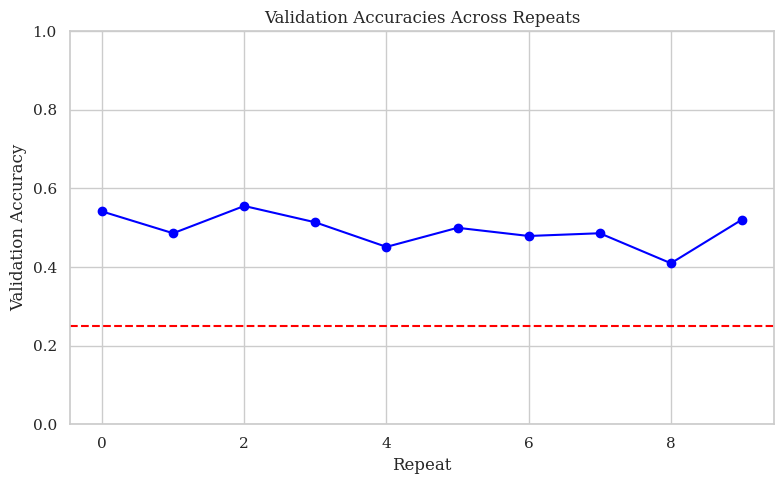

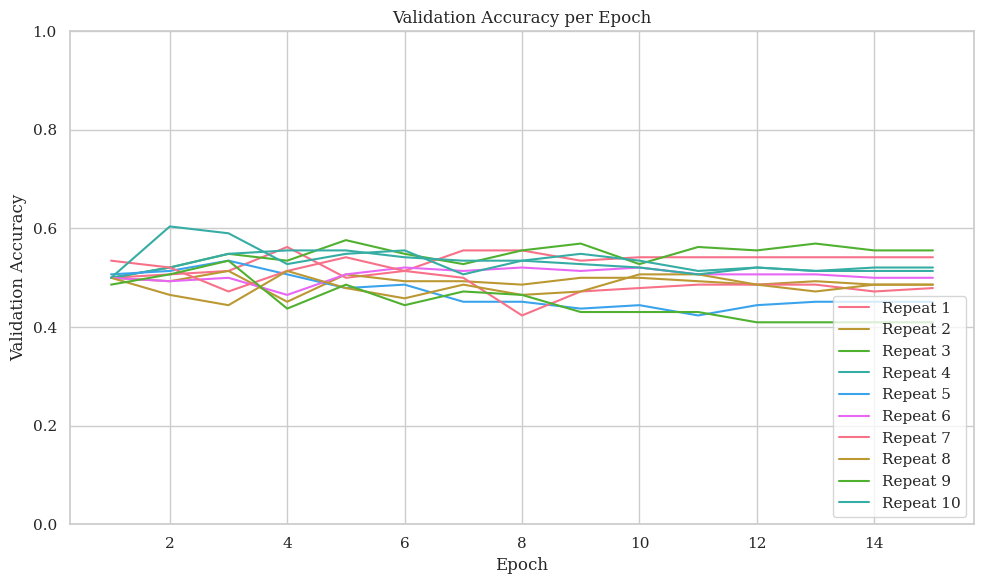

In [34]:
accuracies = results['all_accuracies']
histories = results['all_histories']
epochs = experiment.epochs

# plot validation accuracies across repeats
plt.figure(figsize=(8, 5))
plt.plot(accuracies, marker='o', linestyle='-', color='blue')
plt.axhline(chance_level, color='red', linestyle='--', label='Chance Level (25%)')
plt.title('Validation Accuracies Across Repeats')
plt.xlabel('Repeat')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot validation accuracy curves over epochs for each repeat
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history[:, 'epoch'], history[:, 'valid_accuracy'], label=f'Repeat {i+1}')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
def run_experiments(learning_rate, batch_size, repeats = 10, epochs = 15):
    val_accuracies = []
    epochs_to_best = []
    all_histories = []

    for i in range(repeats):
        print(f"\nRun {i+1}/{repeats}")
        set_random_seeds(seed = 2025 + i, cuda = torch.cuda.is_available())

        data_dirs = ['/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/Nguyen/Long_words', '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/Nguyen/Short_words']
        dataset = NguyenDataset(data_dirs)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])

        X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

        train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
        valid_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

        n_classes = 4
        n_chans = X_train.shape[1]
        input_time_length = X_train.shape[2]

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length = 'auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion = torch.nn.CrossEntropyLoss,
            optimizer = torch.optim.AdamW,
            optimizer__lr = learning_rate,
            train_split = predefined_split(valid_dataset),
            batch_size = batch_size,
            callbacks = ['accuracy'],
            device = 'cuda' if torch.cuda.is_available() else 'cpu',
            classes = list(range(4))
        )

        clf.fit(train_dataset, y = None, epochs = epochs)

        best_epoch = int(np.argmax(clf.history[:, 'valid_accuracy']))
        best_acc = float(clf.history[best_epoch, 'valid_accuracy'])
        val_accuracies.append(best_acc)
        epochs_to_best.append(best_epoch)
        all_histories.append(clf.history)

    return val_accuracies, epochs_to_best, all_histories

In [28]:
# run training
learning_rate = 0.00075
batch_size = 40

accuracies, epochs_needed, histories = run_experiments(learning_rate, batch_size, repeats = 10)


Run 1/10
Final dataset size: (720, 64, 1280), Labels shape: (720,)


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.5399        1.1186       0.5069            0.5069        1.0448  4.7190
      2            0.7014        0.8347       0.5486            0.5486        0.7803  5.3394
      3            0.7951        0.6888       0.5347            0.5347        0.7754  4.6646
      4            0.8420        0.5969       0.5208            0.5208        0.7774  4.8753
      5            0.8715        0.5441       0.5278            0.5278        0.8605  4.8743
      6            0.9062        0.4726       0.4792            0.4792        0.8412  4.6649
      7            0.9306        0.4628       0.4861            0.4861        0.8071  4.7623
      8            0.9097        0.4230       0.4792            0.4792        0.8902  4.7267
      9            0.9462        0.3685       0.5139            0.5139

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.5347        1.1428       0.5139            0.5139        1.0811  5.1150
      2            0.6580        0.8085       0.5139            0.5139        0.8341  4.6589
      3            0.8160        0.6798       0.4375            0.4375        0.8283  4.6066
      4            0.8247        0.6310       0.4514            0.4514        0.8492  4.6201
      5            0.8559        0.5900       0.5000            0.5000        0.8103  4.5575
      6            0.8854        0.4932       0.5347            0.5347        0.8225  4.4920
      7            0.8941        0.4692       0.4792            0.4792        0.8300  4.7071
      8            0.9392        0.3858       0.5208            0.5208        0.8524  4.7690
      9            0.9531        0.3598       0.4375            0.4375

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.5191        1.1509       0.5000            0.5000        1.0782  4.4877
      2            0.6545        0.8312       0.5000            0.5000        0.7873  4.4638
      3            0.7552        0.7022       0.4792            0.4792        0.8261  4.3444
      4            0.8003        0.6275       0.5139            0.5139        0.8299  4.4325
      5            0.8403        0.5451       0.4931            0.4931        0.7803  4.3525
      6            0.8698        0.5533       0.5486            0.5486        0.8283  4.4091
      7            0.8646        0.4903       0.5000            0.5000        0.8804  4.4302
      8            0.9115        0.4501       0.5208            0.5208        0.8490  4.3938
      9            0.9236        0.4537       0.5069            0.5069

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.6024        1.2458       0.5000            0.5000        0.8898  4.6970
      2            0.6736        0.8652       0.5139            0.5139        0.8239  4.3785
      3            0.7292        0.7620       0.5000            0.5000        0.8175  4.4066
      4            0.7934        0.6317       0.5208            0.5208        0.7881  4.3469
      5            0.8090        0.6084       0.5000            0.5000        0.7852  4.3877
      6            0.8854        0.5423       0.5347            0.5347        0.7726  4.4441
      7            0.8993        0.4980       0.5486            0.5486        0.7803  4.4996
      8            0.9010        0.4875       0.5000            0.5000        0.8149  4.4445
      9            0.9149        0.4361       0.5347            0.5347

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.6510        1.1616       0.5347            0.5347        0.8704  4.6573
      2            0.7118        0.8096       0.4931            0.4931        0.8421  4.4281
      3            0.7205        0.7220       0.4722            0.4722        0.8540  4.3616
      4            0.7743        0.6516       0.4722            0.4722        0.8802  4.4045
      5            0.8507        0.5709       0.4583            0.4583        0.8961  4.6355
      6            0.8316        0.5439       0.5000            0.5000        0.8971  4.3880
      7            0.9306        0.4452       0.4722            0.4722        0.8671  4.5006
      8            0.9410        0.4205       0.5278            0.5278        0.8849  4.4059
      9            0.8698        0.4200       0.4653            0.4653

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.5729        1.2275       0.4931            0.4931        0.9003  4.6291
      2            0.7240        0.7739       0.5208            0.5208        0.8756  4.3999
      3            0.7118        0.7248       0.5139            0.5139        0.8829  4.3565
      4            0.7760        0.6425       0.5278            0.5278        0.8616  4.4386
      5            0.8385        0.5661       0.4931            0.4931        0.8766  4.4113
      6            0.8698        0.5019       0.5208            0.5208        0.8345  4.7608
      7            0.9444        0.4367       0.5139            0.5139        0.8110  4.5856
      8            0.9358        0.4397       0.5556            0.5556        0.8066  5.0455
      9            0.9531        0.3842       0.5000            0.5000

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.6458        1.1587       0.5278            0.5278        0.8562  5.0592
      2            0.7135        0.7841       0.5139            0.5139        0.8254  4.9750
      3            0.7691        0.6334       0.5000            0.5000        0.8263  4.7982
      4            0.8438        0.5973       0.4722            0.4722        0.8152  4.5215
      5            0.8385        0.5180       0.5139            0.5139        0.8126  4.5422
      6            0.9045        0.4510       0.4653            0.4653        0.8676  4.5203
      7            0.9201        0.4457       0.5208            0.5208        0.8769  4.4476
      8            0.9392        0.4096       0.4931            0.4931        0.8836  4.5173
      9            0.9410        0.4169       0.4722            0.4722

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.5000        1.1696       0.5000            0.5000        1.5586  4.5435
      2            0.6962        0.7704       0.4931            0.4931        0.8386  4.3867
      3            0.7691        0.6770       0.5347            0.5347        0.7592  4.3908
      4            0.7899        0.6043       0.5139            0.5139        0.7807  4.3657
      5            0.8455        0.5909       0.5000            0.5000        0.7923  4.4125
      6            0.8420        0.5619       0.5000            0.5000        0.8247  4.4341
      7            0.8559        0.5359       0.4792            0.4792        0.8149  4.4718
      8            0.9149        0.4495       0.5208            0.5208        0.8096  4.4157
      9            0.9566        0.4194       0.4931            0.4931

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.5538        1.1914       0.4931            0.4931        1.0398  4.4449
      2            0.6632        0.7815       0.4514            0.4514        0.8441  4.4130
      3            0.7865        0.7031       0.4306            0.4306        0.8599  4.3519
      4            0.8299        0.6168       0.4097            0.4097        0.8385  4.4443
      5            0.8542        0.5918       0.4375            0.4375        0.9157  4.4455
      6            0.8854        0.5734       0.3958            0.3958        0.9054  4.5078
      7            0.9045        0.5152       0.4444            0.4444        0.9110  4.5968
      8            0.9271        0.4775       0.4375            0.4375        0.9644  4.6329
      9            0.9375        0.4010       0.4722            0.4722

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.6406        1.1393       0.5417            0.5417        0.7998  4.6799
      2            0.7274        0.8032       0.5486            0.5486        0.7599  4.4890
      3            0.7535        0.6996       0.5486            0.5486        0.7675  4.4465
      4            0.7865        0.6188       0.5347            0.5347        0.8004  4.5438
      5            0.8524        0.5492       0.5139            0.5139        0.8149  4.5452
      6            0.8750        0.4938       0.5417            0.5417        0.8152  4.5742
      7            0.9149        0.4477       0.5556            0.5556        0.7622  4.7124
      8            0.9010        0.4070       0.4861            0.4861        0.9123  4.5773
      9            0.9479        0.3843       0.5486            0.5486

In [32]:
# run t-tests
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 30.0104, p: 0.0000


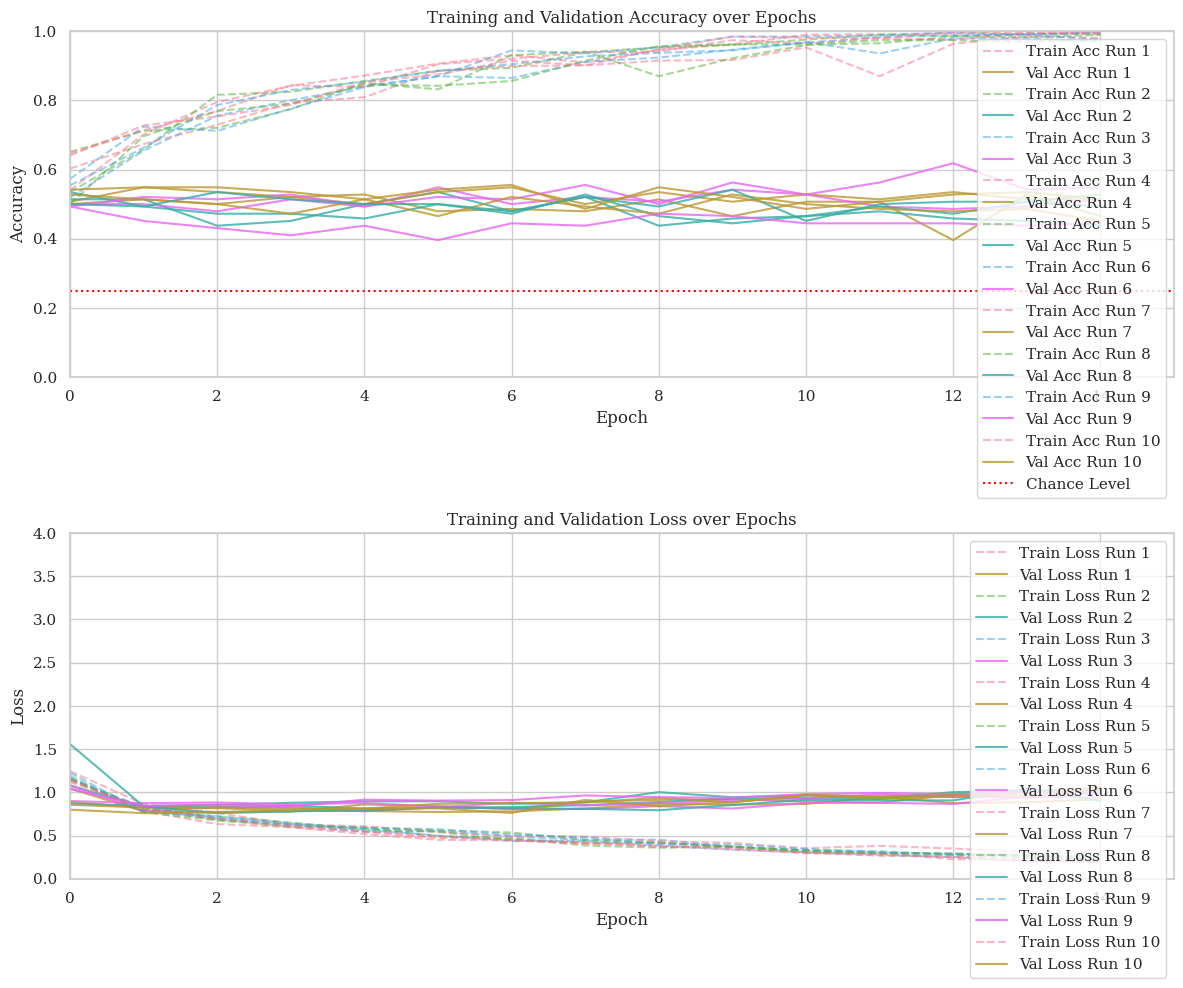

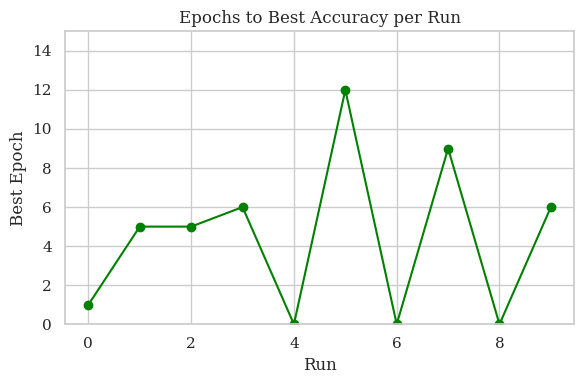

In [31]:
# plot results
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

num_epochs = 15

for i, hist in enumerate(histories):
    axs[0].plot(hist[:, 'train_accuracy'], linestyle='--', alpha=0.5, label=f'Train Acc Run {i + 1}')
    axs[0].plot(hist[:, 'valid_accuracy'], alpha=0.8, label=f'Val Acc Run {i + 1}')
    axs[1].plot(hist[:, 'train_loss'], linestyle='--', alpha=0.5, label=f'Train Loss Run {i + 1}')
    axs[1].plot(hist[:, 'valid_loss'], alpha=0.8, label=f'Val Loss Run {i + 1}')

# plot accuracies per repeat
axs[0].axhline(y=chance_level, color='r', linestyle=':', label='Chance Level')
axs[0].set_title('Training and Validation Accuracy over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, num_epochs)
axs[0].legend()
axs[0].grid(True)

# plot loss per repeat
axs[1].set_title('Training and Validation Loss over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0, 4)
axs[1].set_xlim(0, num_epochs)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# epochs to best accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_needed, marker='o', color='green')
plt.title('Epochs to Best Accuracy per Run')
plt.xlabel('Run')
plt.ylabel('Best Epoch')
plt.ylim(0, num_epochs)
plt.grid(True)
plt.tight_layout()
plt.show()